# Генерация мордочек кошек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
from tensorboard.backend.event_processing import event_accumulator

## Данные
Я использую датасет с картинками мордочек кошек 64*64
15788 штук

In [2]:
image_size = 64
batch_size = 64
latent_dim = 128
learning_rate = 0.001

In [3]:
device = torch.device("cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
dataset = datasets.ImageFolder(root="dataset", transform=transform)

In [6]:
total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

In [7]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

## AutoEncoder

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=4, stride=1, padding=0)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1), 
            nn.Tanh()
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out
    
    def generate(self):
        with torch.no_grad():
            latent_vector = torch.randn(1, latent_dim, 1, 1).to(device)
            generated_img = self.decoder(latent_vector).cpu()
            generated_img = (generated_img + 1) / 2
            
            img = generated_img[0].permute(1, 2, 0).numpy()
            plt.figure(figsize=(10, 4))
            plt.imshow(img)
            plt.axis("off")
            plt.show()

## Инициализация модели

In [10]:
model = AutoEncoder().to(device)

In [11]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.L1Loss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
writer = SummaryWriter(log_dir="logs")

## Обучение


In [12]:
epoch = 0
best_loss = np.inf
early_stop_counter = 0
patience = 3

In [13]:
while early_stop_counter <= patience:
    model.train()
    running_loss = 0.0
    
    for images, _ in tqdm(train_loader, desc=f"Epoch {epoch}"):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    writer.add_scalar("Loss/train", avg_loss, epoch)
    
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            test_running_loss += loss.item()
    
    test_avg_loss = test_running_loss / len(test_loader)
    writer.add_scalar("Loss/test", test_avg_loss, epoch)
    
    if (best_loss - avg_loss) > 0.01:
        best_loss = avg_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    scheduler.step()
    epoch += 1
writer.close()

Epoch 16: 100%|██████████| 222/222 [01:25<00:00,  2.61it/s]


### Посмотрим на графики ошибок

In [14]:
event_acc = event_accumulator.EventAccumulator("logs")
event_acc.Reload()

In [15]:
loss_train_events = event_acc.Scalars("Loss/train")
loss_test_events = event_acc.Scalars("Loss/test")

In [16]:
epochs_train = [e.step for e in loss_train_events]
avg_loss_train = [e.value for e in loss_train_events]

In [17]:
epochs_test = [e.step for e in loss_test_events]
avg_loss_test = [e.value for e in loss_test_events]

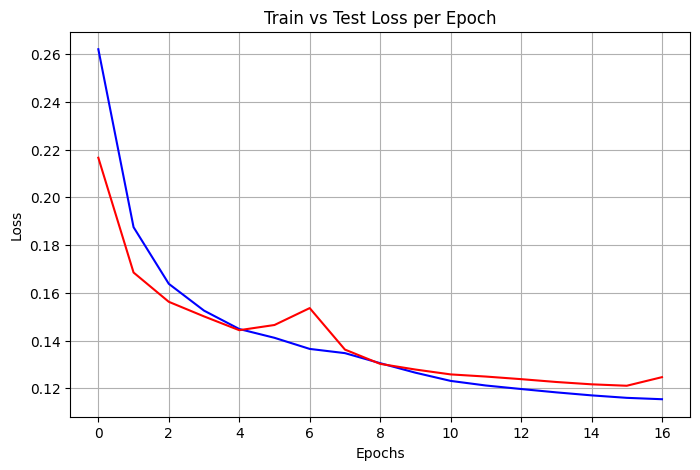

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_train, avg_loss_train, label="Train Loss", color="blue")
plt.plot(epochs_test, avg_loss_test, label="Test Loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Проверка качества модели

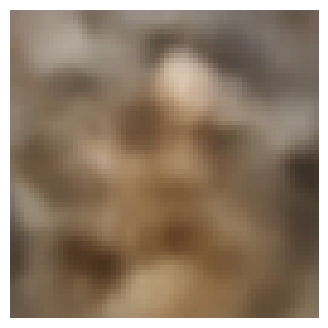

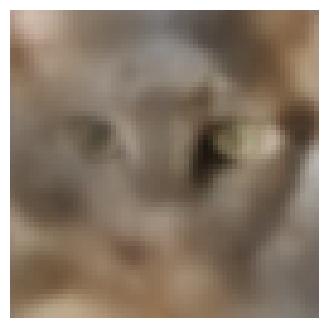

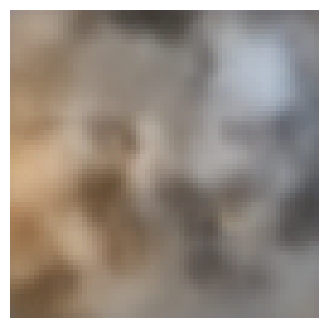

In [19]:
model.generate()
model.generate()
model.generate()

Вот такие уродцы получились

## Gif

In [20]:
def interpolate(a, b, steps=50):
    interpolated_images = []
    alpha_values = np.linspace(0, 1, steps)
    for alpha in alpha_values:
        z = (1 - alpha) * a + alpha * b
        img = model.decoder(z.unsqueeze(0)).cpu().detach().squeeze(0)
        img = (img + 1) / 2
        interpolated_images.append((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
    return interpolated_images

In [21]:
images, _ = next(iter(test_loader))
images = images.to(device)

In [22]:
with torch.no_grad():
    A, B = model.encoder(images[:2])

In [23]:
frames = interpolate(A, B, steps=50)

In [24]:
imageio.mimsave("cat.gif", frames, duration=0.1)